# **Instalar TensorFlow en Colab e importar librerias**

Ejecutar, en caso de pérdida de conexión

In [1]:
#desinstalar version por defecto de tensorflow (2.9.x)
!pip uninstall tensorflow
#instalar version 2.4.1 (version estable)
!pip install tensorflow==2.4.1

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 14.8 MB 38.0 MB/s 
     |████████████████████████████████| 2.9 MB 39.2 MB/s 
     |████████████████████████████████| 462 kB 68.1 MB/s 
     |███████

In [1]:
#librerias para el manejo de archivos
import os
import glob
import xml.etree.ElementTree as ET

#librerias para entrenamiento
import pandas as pd
import tensorflow as tf
#verificar version de tensorflow instalada (ultimas versiones de tensorflow da errores en Colab, V2.4.1 es estable)
print(tf.__version__)

2.4.1


# **Montar carpeta del entrenamiento en Colab**

Ejecutar, en caso de pérdida de conexión

In [ ]:
#libreria para conectar colab con drive 
from google.colab import drive
#montar drive en maquina virtual de colab
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# **Clonar modelo de TensorFlow e instalar API (protos)**

In [3]:
#clonar modelos
!git clone --q https://github.com/tensorflow/models.git
%cd models/research
#compilar protos
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


# **Instalar y verificar modelo**

'tensorflow==2.8.0',
'tf-models-official==2.8.0',
'tensorflow_io==0.23.1',
'keras==2.8.0',

In [4]:
#instalar setup.py (modelo)
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

#verificar instalacion, [OK] se encuentra instalado correctamente
!python object_detection/builders/model_builder_tf2_test.py

#moverse al directorio ../data/
%cd /mydrive/entrenamientoCarnes/data/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 7.0 MB/s 
     |████████████████████████████████| 352 kB 48.6 MB/s 
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 2.2 MB 52.4 MB/s 
     |████████████████████████████████| 23.1 MB 1.1 MB/s 
     |████████████████████████████████| 2.1 MB 41.7 MB/s 
     |████████████████████████████████| 25.0 MB 1.4 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |█

# **Generar archivo CSV y el archivo "label_map.pbtxt"**

Usar el archivo xml_to_csv.py para crear los archivos ***test_labels.csv*** y ***train_labels.csv***

Además, este script genera el archivo ***label_map.pbtxt*** que contiene el nombre de las carnes a clasificar. 

In [6]:
#pasar a csv toda la informacion generada durante el etiquetado
def xml_to_csv(path):
  #listas para almacenar nombres de las clases 
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  #columnas del csv
  #nombre archivo, dimensiones,clasee, coordenadas del recuadro de etiqueta
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

#generar .pbtxt (contiene info de las clases)
label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')   

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


# **Crear archivos train.record y test.record**


Ejecutar el script *generate_tfrecord.py* esto crea los archivos *train.record* y *test.record*



In [7]:
/#0Para archivo train.record
!python /mydrive/entrenamientoCarnes/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#Para archivo test.record
!python /mydrive/entrenamientoCarnes/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

groups: 100% 1633/1633 [23:09<00:00,  1.18it/s]
Successfully created the TFRecords: /content/gdrive/MyDrive/entrenamientoCarnes/data/train.record
groups: 100% 809/809 [11:25<00:00,  1.18it/s]
Successfully created the TFRecords: /content/gdrive/MyDrive/entrenamientoCarnes/data/test.record


# **Descargar modelo pre-entrenado de TensorFlow** 


Se elige el modelo llamado: **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz**, es liviano a comparación de una CNN (se utiliza en dispositivos móviles)

Modelos: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md.

In [ ]:
#descargar modelo ssd_mobilenet_v2
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
#descomprimir modelo
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2022-09-11 10:35:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.200.128, 2404:6800:4003:c11::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.200.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M   110MB/s    in 0.2s    

2022-09-11 10:35:32 (110 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

# **Realizar las configuraciones necesarias en el archivo de .config del modelo pre-entrenado descargado**

In [ ]:
#confguraciones a realizar:
'''
Cambiar la linea num_classes a el numero de carnes a clasificar (8 clases, se considera una adicional para recipiente vacio).
Cambiar la ruta del archivo test.record, train.record y labelmap.pbtxt (redireccionar a ubicacion en drive).
Cambiar la ruta de la linea fine_tune_checkpoint (carpeta del modelo pre-entrenado descargado anteriormente).
Cambiar linea fine_tune_checkpoint_type a la palabra "detection"
Cambiar la linea batch_size a cualquier valor multiplo de 8 dependiendo de la capacidad de la GPU del computador (colab soporta hasta 256 batch size, pero la presicion es baja).
'''
!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/entrenamientoCarnes/data

# **15) Empezar el entrenamiento del modelo** 


In [5]:
%cd /content/models/research/object_detection
!pip list|grep opencv

!pip uninstall opencv-python
!pip uninstall opencv-contrib-python 
!pip uninstall opencv-python-headless

# versiones de opencv que funcionan bien con TF 2.4
!pip install opencv-python==4.1.2.30
!pip install opencv-contrib-python==4.1.2.30
!pip install opencv-python-headless==4.1.2.30

/content/models/research/object_detection
opencv-contrib-python         4.6.0.66
opencv-python                 4.6.0.66
opencv-python-headless        4.6.0.66
Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_pyth

In [ ]:
#librerias cuda, en caso de error DNN Library durante entrenamiento (versiones de cudnn y cuda dependen de version de TF, revisar pagina oficial)
!apt install --allow-change-held-packages libcudnn8=8.0.5.39-1+cuda11.0


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.0.5.39-1+cuda11.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
# empezar con entrenamiento
# se desea conseguir total_loss < 0.1

!python model_main_tf2.py --pipeline_config_path=/mydrive/entrenamientoCarnes/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/entrenamientoCarnes/training --alsologtostderr

2022-09-11 14:51:21.707363: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0911 14:51:21.717432 140570984331136 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0911 14:51:21.735651 140570984331136 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0911 14:51:21.735834 140570984331136 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0911 14:51:21.960766 140570984331136 deprecation.py:343] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment


## Script para evitar que Colab entre en modo suspensión

Presionar (Ctrl + Shift + i) . Ir a la "Consola" y copiar el siguiente código.

```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```



# **TensorBoard**

In [ ]:
#  tensorBoard para visualizar proceso de entrenamiento, graficas de error, etc.
#!pip install tensorboard
!kill 598
#%load_ext tensorboard
%tensorboard --logdir '/content/gdrive/MyDrive/entrenamientoCarnes/training'

In [13]:
%cd /content/models/research/object_detection
!pip install keras==2.1.5
!pip install tensorflow_io==0.23.1
!pip install tensorflow==2.4.1

/content/models/research/object_detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl (394.3 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uninstalling grpcio-1.48.1:
      Successfully uninstalled grpcio-1.48.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstalling ten

# **Exportar gráfica de inferencia**

In [19]:
!python exporter_main_v2.py --trained_checkpoint_dir=/mydrive/entrenamientoCarnes/training --pipeline_config_path=/content/gdrive/MyDrive/entrenamientoCarnes/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /mydrive/entrenamientoCarnes/data/inference_graph

2022-09-11 18:04:32.463061: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0911 18:04:36.913448 139791698548608 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0911 18:05:03.684429 139791698548608 save_impl.py:72] Skipping full serialization of Ker

Loading model...

Done!


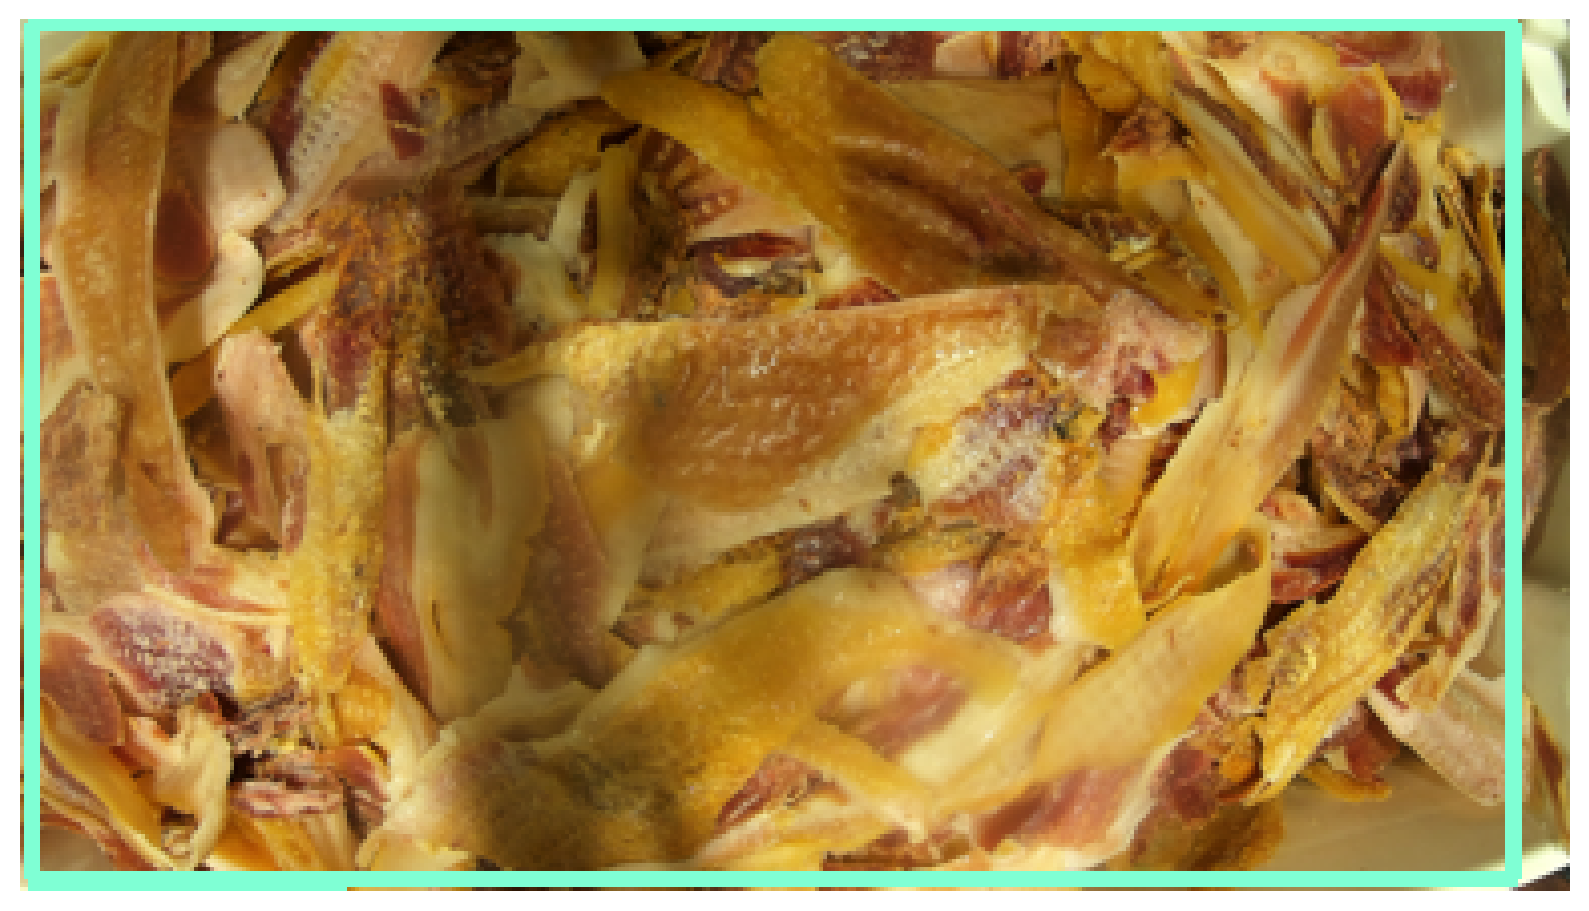

In [26]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (10, 7)
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/mydrive/entrenamientoCarnes/data/inference_graph/saved_model"
print('Loading model...', end='')

detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

category_index=label_map_util.create_category_index_from_labelmap("/mydrive/entrenamientoCarnes/data/label_map.pbtxt",use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))
'''
AQUI SE ELIGE LA RUTA DE LAS IMAGENES A CLASIFICAR
'''
image_path = "/mydrive/entrenamientoCarnes/C06.png"

image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, 
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()